In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split as tts
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [41]:
# set hyper-parameters and call init
reg_strngth = 1000 #regularization strength
learning_rate = 0.0001

In [42]:
# Feature Selection
def remove_correlated_features(X): # X is a Data Frame
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool) #initialization
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]): # for not checking elements twice and deleting both columns
            if corr.iloc[i,j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=0, inplace=True)
    return X

In [43]:
def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return (X,columns_dropped)


In [44]:
def compute_cost(W, X, Y):
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0 # like max(0, distances) because in the end the distances should be >= 0
    hinge_loss = reg_strngth * (np.sum(distances) / N)
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost

In [45]:
def calculate_cost_gradient(W, X_batch, Y_batch):
    if type(Y_batch) == np.float64 or type(Y_batch) == np.int64 : # if data is just a number change it to an arry to dot operation be possible
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])
    distance = 1.0 - (Y_batch * np.dot(X_batch, W))
    if type(distance) == np.float64 or type(distance) == np.int64:
         distance = np.array([distance])
    dw = np.zeros(len(W))
    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:           
            di = W - (reg_strngth * Y_batch[ind] * X_batch[ind])
        dw += di
    dw  = dw / len(Y_batch)
    return dw


In [46]:
def sgd(features, outputs):
    max_epochs = 150
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf") #biggest number that let algorithme continue after first iteration
    cost_threshold = 0.1 # to end itreation if reached this percision
    
    for epoch in range(1, max_epochs):
        X, Y = shuffle(features, outputs)#for random sampleing
        #print(X)
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)  
            #checking convegence with 2 conditions 
            if epoch == 2 ** nth or epoch == max_epochs - 1:
                cost = compute_cost(weights, features, outputs)
                if abs(prev_cost - cost) < cost_threshold * prev_cost:
                     return weights
            prev_cost = cost 
            nth += 1      
    return weights


In [47]:
def SVM(X, Y):
    #inserting 1 inevery row for interceptb based on lecture slides
    X.insert(loc=len(X.columns), column='intercept', value=1)
    X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

    X_train = X_train.to_numpy()
    print("X")
    y_train = y_train.to_numpy()
    print("Y")
    W = sgd(X_train,y_train)
    print("done")

    #testing the model 
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()
   # X_test = X_test[:,np.newaxis]
    y_predict = np.array([])
    for i in range(X_test.shape[0]):
        test = X_test[i]
        yp = np.sign(np.dot(test.tolist(), W.tolist()))
        y_predict = np.append(y_predict, yp) 
    return y_predict

In [48]:
def label_maker(Y,AgeMap,y_train_n, y_test_n):
    y = Y.map(AgeMap).tolist()
    y_test = [y[i] for i in y_test_n] 
    y_train = [y[i] for i in y_train_n] 
    y = pd.Series(y)
    y_test = pd.Series(y_test)
    y_train = pd.Series(y_train)
    return (y, y_train, y_test)

In [49]:
def normalization(X,Y):
    #filter features
    X = remove_correlated_features(X)   
    #X, columns_dropped = remove_less_significant_features(X,Y)  
    #normalization
    X_normalized = MinMaxScaler().fit_transform(X.values)
    X = pd.DataFrame(X_normalized)
    return X

In [50]:
Age_map1 = {'Old':1, 'Middle':-1, 'Young':-1} # mapping string to numeric
Age_map2 = {'Old':-1, 'Middle':1, 'Young':-1}
Age_map3 = {'Old':-1, 'Middle':-1, 'Young':1}
Age_map = {'Old':3, 'Middle':2, 'Young':1}  

In [61]:
d = pd.read_csv('RM.csv') 
rng = list(range(0, d.shape[0]))
Y = d['Age']
d.drop(d.columns[[ 0]], axis=1, inplace=True)
d.drop(['Age'], axis=1, inplace=True)
X = d.copy()
X.insert(loc=len(X.columns), column='intercept', value=1)

In [52]:
X_train, X_test, y_train_n, y_test_n = tts(X, rng, test_size=0.2, random_state=42)

In [53]:
Y1, y_train1, y_test1 = label_maker(Y,Age_map1,y_train_n, y_test_n)
Y2, y_train2, y_test2 = label_maker(Y,Age_map2,y_train_n, y_test_n)
Y3, y_train3, y_test3 = label_maker(Y,Age_map3,y_train_n, y_test_n)
Y, y_train, y_test = label_maker(Y,Age_map,y_train_n, y_test_n)

In [15]:
W1 = sgd(X_train.to_numpy(),y_train1)
W2 = sgd(X_train.to_numpy(),y_train2)
W3 = sgd(X_train.to_numpy(),y_train3)

In [16]:
def multiclass_SVM(W1, W2, W3, X_test):
    X_test = X_test.to_numpy()
    y_predict = np.array([])
    for i in range(X_test.shape[0]):
        yp = []
        test = X_test[i]
        yp.append(np.dot(test.tolist(), W1.tolist()))
        yp.append(np.dot(test.tolist(), W2.tolist()))
        yp.append(np.dot(test.tolist(), W3.tolist()))
        #print(yp)
        y_predict = np.append(y_predict,  yp.index(max(yp))+1 ) 
    return y_predict

In [17]:
y_predict = multiclass_SVM(W1, W2, W3, X_test)    
conf_matrix = confusion_matrix(y_test, y_predict)

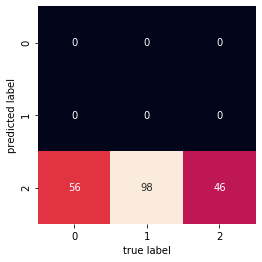

In [18]:
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [19]:
X1 = d.copy()
X2 = d.copy()
X3 = d.copy()

y1_predict = SVM(X1,Y1) #Old seperator
y2_predict = SVM(X2,Y2) #Middle seperator
y3_predict = SVM(X3,Y3) #Young seperator

y1_predict[np.where(y1_predict == -1)] = 0
y2_predict[np.where(y1_predict == -1)] = 0
y2_predict[np.where(y1_predict == -1)] = 0

y1_predict = y1_predict + 2
y2_predict = y2_predict + 1

X
Y
done
X
Y
done
X
Y
done


In [34]:
n = y_test.shape[0]
predict = np.zeros((n,1))

for i in range(n):
    if y_test[i] == y1_predict[i]:
        predict[i] = 3
    elif y_test[i] == y2_predict[i]:
        predict[i] = 2
    elif y_test[i] == y3_predict[i]:
        predict[i] = 1

Text(91.68, 0.5, 'predicted label')

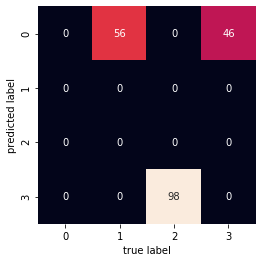

In [22]:
plt.figure(2)        
cnf_matrix = confusion_matrix(y_test, predict)
sns.heatmap(cnf_matrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [24]:
X_train, X_test, y_train_n, y_test_n = tts(X, Y, test_size=0.2, random_state=42)
model = SVC()

In [25]:
# define ovo strategy
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X_train, y_train)
# make predictions
y_predict = ovr.predict(X_test)

Text(91.68, 0.5, 'predicted label')

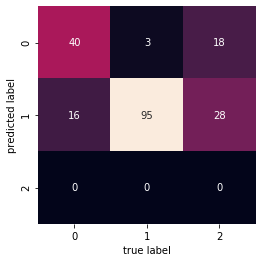

In [26]:
mat = confusion_matrix(y_test, y_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [27]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yfit = clf.predict(X_test)

Text(91.68, 0.5, 'predicted label')

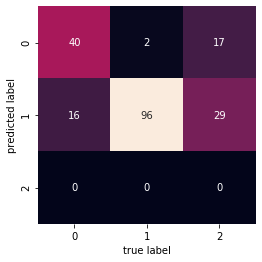

In [28]:
mat = confusion_matrix(y_test, yfit)
plt.figure(4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [64]:
X = normalization(d,Y)
X_train, X_test, y_train_n, y_test_n = tts(X, rng, test_size=0.2, random_state=42)


Y1, y_train1, y_test1 = label_maker(Y,Age_map1,y_train_n, y_test_n)
Y2, y_train2, y_test2 = label_maker(Y,Age_map2,y_train_n, y_test_n)
Y3, y_train3, y_test3 = label_maker(Y,Age_map3,y_train_n, y_test_n)
Y, y_train, y_test = label_maker(Y,Age_map,y_train_n, y_test_n)


W1 = sgd(X_train.to_numpy(),y_train1)
W2 = sgd(X_train.to_numpy(),y_train2)
W3 = sgd(X_train.to_numpy(),y_train3)

In [ ]:
y_predict = multiclass_SVM(W1, W2, W3, X_test)    

In [65]:
conf_matrix = confusion_matrix(y_test, y_predict)

Text(91.68, 0.5, 'predicted label')

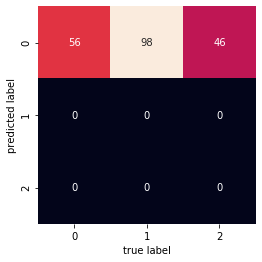

In [66]:
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [67]:
X1 = normalization(X,Y1)
X2 = normalization(X,Y2)
X3 = normalization(X,Y3)

y1_predict = SVM(X1,Y1) #Old seperator
y2_predict = SVM(X2,Y2) #Middle seperator
y3_predict = SVM(X3,Y3) #Young seperator

y1_predict[np.where(y1_predict == -1)] = 0
y2_predict[np.where(y1_predict == -1)] = 0
y2_predict[np.where(y1_predict == -1)] = 0

y1_predict = y1_predict + 2
y2_predict = y2_predict + 1

X
Y
done
X
Y
done
X
Y
done


In [68]:
n = y_test.shape[0]
predict = np.zeros((n,1))

for i in range(n):
    if y_test[i] == y1_predict[i]:
        predict[i] = 3
    elif y_test[i] == y2_predict[i]:
        predict[i] = 2
    elif y_test[i] == y3_predict[i]:
        predict[i] = 1

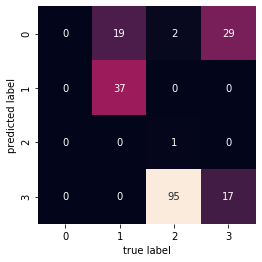

In [69]:
cnf_matrix = confusion_matrix(y_test, predict)
sns.heatmap(cnf_matrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label'); 

In [70]:
X_train, X_test, y_train_n, y_test_n = tts(X, Y, test_size=0.2, random_state=42)
model = SVC()
# define ovo strategy
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X_train, y_train)
# make predictions
y_predict = ovr.predict(X_test)

Text(91.68, 0.5, 'predicted label')

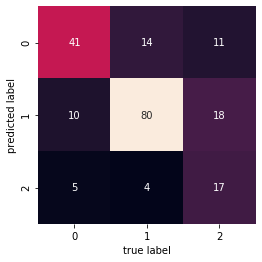

In [71]:
mat = confusion_matrix(y_test, y_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [72]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yfit = clf.predict(X_test)   

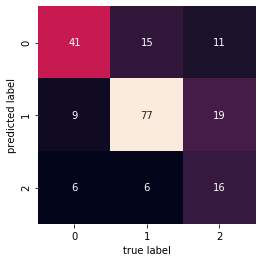

In [73]:
mat = confusion_matrix(y_test, yfit)
plt.figure(4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
